<img src="./images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Superposition, Entanglement, Bell states, and the CHSH inequality*_ 
© IBM Research

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the Quantum Experience consult the [Quantum Experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0) or check-out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Jay Gambetta, Antonio Córcoles

## Introduction
Many people tend to think quantum physics is hard math. This is actually not true, quantum concepts are very similar to linear algebra classes you probably did in first year university or even at high school. What is hard about quantum physics is that there is no simple underlying theory. Instead, you need to accept counter-intuitive ideas. In putting together the Quantum Experience, we feel that you can get far by understanding two principles. 
1. A physical system in a perfectly definite state can still behave randomly.
2. Two systems that are too far apart to influence each other can nevertheless behave in ways that, though individually random, are somehow strongly correlated.

## Getting Started
Please see the Getting+Started+with+the+QX+API if you would like to understand the API better. However for this script simply import the following preamble once you have made your own Qconfig.py file containing your token from Quantum Experience. 

In [1]:
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.linalg
%matplotlib inline
import time
from IBMQuantumExperience import IBMQuantumExperience
from Qhelpers.basicPlotter import plotHistogram
from Qhelpers.misc import getData
from Qhelpers.misc import combineJobs
from Qhelpers.misc import averageData

import Qconfig
api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APItoken, Qconfig.config)

## Superposition

The core idea behind principle 1 is quantum superposition. By measuring superposition states in different bases, we can get results that can be random or deterministic. To show this, we will start by introducing the Hadamard gate, $H$. Let's assume for now that this gate is like flipping a coin. It has two outcomes and each occurs with equal probability. If we do this thought experiment, we say that on average we will measure as many heads as we do tails. Let heads be $|0\rangle$ and $|1\rangle$ be tails. 

Let's run the quantum version of this experiment. 

The experiment consists of first preparing the qubit in the ground state, then applying the Hadamard gate (coin flip), and then measuring the state of the qubit. Repeat the experiment 1024 times (shots). Correctly, you will predict half the outcomes will be in the $|0\rangle$ state and half will be in the $|1\rangle$ state.

Try the program below. It is seperated into three sections: making the QASM file, running on the device (real), and getting and plotting the data as a histogram. 

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


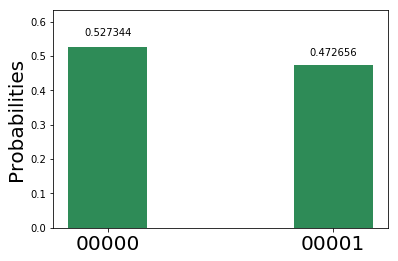

In [2]:
programSuperposition = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
creg c[1];
h q[0];
measure q[0] -> c[0];
"""

qasms = [{'qasm' : programSuperposition}]
device = 'real'
shots = 1024
out = api.runJob(qasms,device,shots,maxCredits=3)
jobids=[out['id']]
results=combineJobs(jobids, api, wait=20, timeout=240)
data=getData(results,0)
plotHistogram(data)

Here we see that, much like a coin flip, we get 50/50 within projective noise. Now let's run an experiment with two $H$ gates. If this was a coin flip, we would still predict a 50/50 distribution. Let's try the experiment!

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


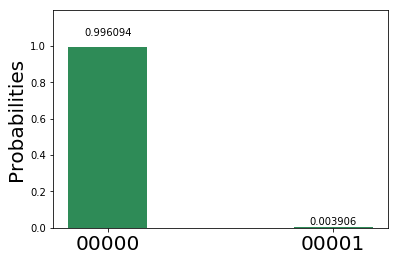

In [3]:
programTwoHadamard = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
creg c[1];
h q[0];
barrier q;
h q[0];
measure q[0] -> c[0];
"""

qasms = [{'qasm' : programTwoHadamard}]
device = 'real'
shots = 1024
out = api.runJob(qasms,device,shots,maxCredits=3)
jobids=[out['id']]
results=combineJobs(jobids, api, wait=20, timeout=240)   
data=getData(results,0)
plotHistogram(data)

Here we see that, unlike the classical case, with high probability the outcome is all in the $|0\rangle$ state. This shows that quantum randomness is not like a classical coin flip. In both cases, the system (without noise) is in a definite state but only the first case behaves randomly. This is because, in the first case, we make a uniform superposition $(|0\rangle+|1\rangle)/\sqrt{2}$ and measure in the computational basis. In the second case, you can think of the second $H$ as changing the measurement basis from the computational to the superposition basis.
$$H: |0\rangle  \rightarrow  |+\rangle=\frac{|0\rangle+|1\rangle}{\sqrt{2}}$$
$$H: |1\rangle \rightarrow |-\rangle=\frac{|0\rangle-|1\rangle}{\sqrt{2}}$$
Therefore, if the measurement gives 0, we can conclude that the system was in the $|+\rangle$ state before the second $H$ gate, and if we obtain 1, it means the system was in the $|-\rangle$ state. In the above experiment we see that the outcome is mainly 0, suggesting that our system was in the $|+\rangle$ superposition state before the second $H$ gate. 


The math is best understood if we represent the quantum state by a two-dimensional vector over the complex numbers. The computational (or standard) basis corresponds to the following pair of column vectors

$$|0\rangle =\begin{pmatrix} 1 \\ 0 \end{pmatrix}$$
$$|1\rangle =\begin{pmatrix} 0 \\ 1 \end{pmatrix}$$

which in Python can be represented by

In [4]:
Zero = np.array([[1],[0]])
One = np.array([[0],[1]])

An arbitrary state $|\psi\rangle = \alpha |0\rangle + \beta |1\rangle$ is a weighted sum of these vectors with $|\alpha|^2+ |\beta|^2 =1$.

A standard measurement, known in quantum mechanics as a projective or von Neumann measurement, takes any superposition state of the qubit and projects it to either the state $|0\rangle$  or the state $|1\rangle$ with a probability determined by:

$$P(i) = |\langle i|\psi\rangle|^2$$ 

We have written the Python function StateOverlap to return this: 

In [5]:
StateOverlap = lambda state1, state2: np.absolute(np.dot(state1.conj().T,state2))**2

Now that we have a simple way of going from a state to the probability distribution of a standard measurement, we can go back to the case of a superposition made from the Hadamard gate. The Hadamard gate is defined by the matrix:

$$ H =\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$$

The $H$ gate acting on the state $|0\rangle$ gives:

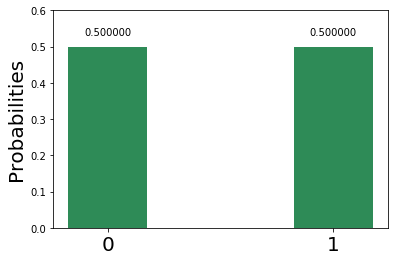

In [6]:
Hadamard = np.array([[1,1],[1,-1]],dtype=complex)/np.sqrt(2)
psi1 = np.dot(Hadamard,Zero)
P0 = StateOverlap(Zero,psi1)
P1 = StateOverlap(One,psi1)
plotHistogram({'0' : P0, '1' : P1})

which is the ideal version of the first experiment. 

The second experiment involves applying the Hadamard gate twice. While matrix multiplication shows that the product of two Hadamards is the identity operator, meaning that the state $|0\rangle$ remains unchanged, here we would rather interpret this as doing a measurement in the superposition basis. Using the above definitions, you can show that H transforms the computational basis to the superposition basis.

In [7]:
print(np.dot(Hadamard,Zero))
print(np.dot(Hadamard,One))

[[ 0.70710678+0.j]
 [ 0.70710678+0.j]]
[[ 0.70710678+0.j]
 [-0.70710678+0.j]]


## Entanglement

The core idea behind principle 2 is entanglement. Entanglement is not just perfect (classical) correlation. If you and I read the same paper we will have the same information, and if a third person comes along and reads the same paper they <i>also</i> will have this information. All these people are perfectly correlated. If we separate them, they will still remain correlated. 

If you and I read a quantum paper we will not learn what the paper says until we get together and share our information. However, when we are together we can ask more questions about this information than we initially thought possible. Thus, quantum entanglement goes much further than perfect correlation.

To demonstrate this we need to define the CNOT gate and the composition of two systems. The convention we use in the Quantum Experience is to label states by writing the first qubit's name in the rightmost position, thereby allowing us to easily convert from binary to decimal. This results in us defining the tensor product between operators $q_0$ and $q_1$ by $q_1\otimes q_0$. 

Taking $q_0$ as the control and $q_1$ as the target, the CNOT with this representation is given by

$$ CNOT =\begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 1\\0& 0& 1 & 0\\0 & 1 & 0 & 0 \end{pmatrix},$$

which is non-standard in the quantum community but allows the best connection to classical computing, where the LSB is typically on the right.

Using the Kronecker product, we can make the four computational basis states: 

In [8]:
ZeroZero=np.kron(Zero,Zero)
ZeroOne=np.kron(Zero,One)
OneZero=np.kron(One,Zero)
OneOne=np.kron(One,One)
CNOT = np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]],dtype=complex)

To make the Bell state $|\psi\rangle= (|00\rangle+|11\rangle)/\sqrt{2}$ from the initial state $|00\rangle$, the quantum circuit first applies a Hadmard on $q_0$ and then a CNOT from $q_0$ to $q_1$. On the Quantum Experience this is done by using the script:

In [9]:
programBell = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];"""

device = 'real'
shots = 1024

Let's start by asking questions about the first qubit. Let's see if it is in a definite state in the computational basis. We will do this by measuring just $q_0$. 

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


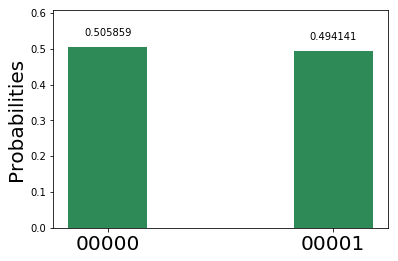

In [10]:
programBellZI= programBell + """\nmeasure q[0] -> c[0];
"""

qasms = [{'qasm' : programBellZI}]
out = api.runJob(qasms,device,shots,maxCredits=3)
jobids=[out['id']]
results=combineJobs(jobids, api, wait=20, timeout=240)
data=getData(results,0)
plotHistogram(data)

Here we see that it is random. Half the time it is in the $|0\rangle$ and the other half is in the $|1\rangle$ state. But maybe it is like the superposition. Maybe the qubit has a perfectly definite state and we were measuring in another basis.  What would you expect if you did the experiment and measured in the superposition basis? Recall we do this by adding a $H$ gate before the measurement. Lets try it.

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


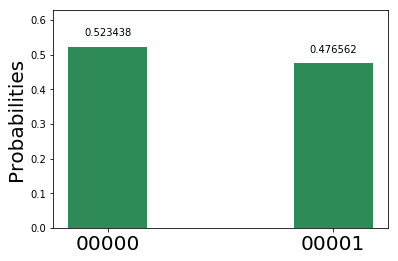

In [11]:
programBellXI= programBell + """\nh q[0]; \nmeasure q[0] -> c[0];
"""

qasms = [{'qasm' : programBellXI}]
out = api.runJob(qasms,device,shots,maxCredits=3)
jobids=[out['id']]
results=combineJobs(jobids, api, wait=20, timeout=240)
data=getData(results,0)
plotHistogram(data)

Here we see again it is random. So it is both random when we measure the first qubit in the standard basis and in the superpostion basis. We know nothing about the first qubit. What about the second qubit? Below we run experiments that measure in the computational and superpostion basis of the second qubit.

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


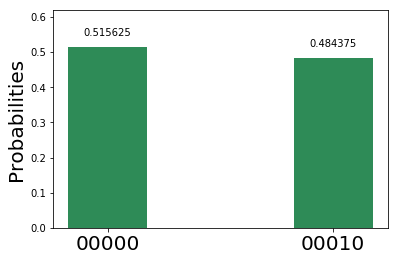

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


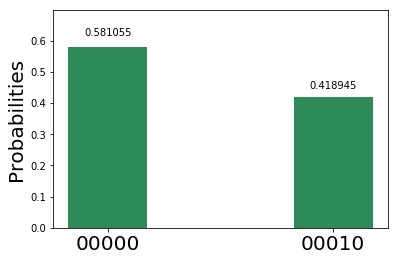

In [12]:
programBellIZ= programBell + """\nmeasure q[1] -> c[1];
"""

qasms = [{'qasm' : programBellIZ}]
out = api.runJob(qasms,device,shots,maxCredits=3)
jobids=[out['id']]
results=combineJobs(jobids, api, wait=20, timeout=240)
data=getData(results,0)
plotHistogram(data)

programBellIX= programBell + """\nh q[1]; \nmeasure q[1] -> c[1];
"""

qasms = [{'qasm' : programBellIX}]
out = api.runJob(qasms,device,shots,maxCredits=3)
jobids=[out['id']]
results=combineJobs(jobids, api, wait=20, timeout=240)
data=getData(results,0)
plotHistogram(data)

Again all the experiments give random outcomes. It seems we know nothing about our system. In the analogy above, this would be two different readers reading a quantum paper and extracting no information whatsoever from it.

However, if they'd get together and both measure in the computation basis what do you expect? 

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


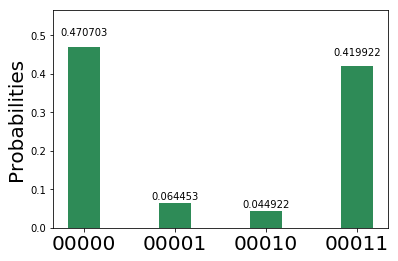

In [13]:
programBellZZ= programBell + """\nmeasure q[0] -> c[0];\nmeasure q[1] -> c[1];
"""

qasms = [{'qasm' : programBellZZ}]
out = api.runJob(qasms,device,shots,maxCredits=3)
jobids=[out['id']]
results=combineJobs(jobids, api, wait=20, timeout=240)
data=getData(results,0)
plotHistogram(data)

Here we see that if with high probability if $q_0$ is in state 0 so is $q_1$ and same for state 1. They are perfectly correlated.

What about in the superposition basis? Lets run the experiment and see. 

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


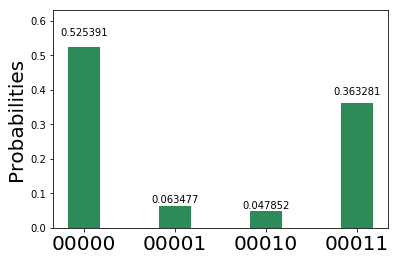

In [14]:
programBellXX= programBell + """\n h q[0]; \n h q[1]; \nmeasure q[0] -> c[0];\nmeasure q[1] -> c[1];
"""

qasms = [{'qasm' : programBellXX}]
out = api.runJob(qasms,device,shots,maxCredits=3)
jobids=[out['id']]
results=combineJobs(jobids, api, wait=20, timeout=240)
data=getData(results,0)
plotHistogram(data)

Here we see that (up to experimental noise) the system has perfect correlations in both the computation basis and the superpostion basis. This means that if $q_0$ is measured in state $|0\rangle$ then we know $q_1$ is in this state, and furthermore if $q_0$ is measured in state $|+\rangle$ then we know $q_1$ is in this state. These correlations have lead to a lot of confusion in science mainly because we try to find analogies between the weird concept of quantum entanglement and everyday experiences and this leads inevitably to many inconsistencies.

## CHSH inequality 

In classical physics there are phenomena that can appear random to an observer but are far from being so. For example, the single toss of a coin. Assuming a fair coin, of course, will that give a random outcome? It may appear so. But the apparent randomness stems simply from the fact that we cannot easily measure everything related to the toss of the coin: speed, angular momentum, ambient conditions ... with enough accuracy. These variables are 'hidden' to the classical observer. From the beginnings of quantum mechanics, some people pondered that the randomness inherent to the quantum theory might equally be due to hidden variables. This was for a while a very hot topic of discussion in quantum mechanics.

In 1964, John Stewart Bell proposed a theorem that suggests that there are no hidden variables in quantum mechanics. It would not be crazy to state that Bell's theorem might be one of the most profound discoveries ever made in history of science. At the core of Bell's theorem is the famous Bell inequality. Here, we'll use a refined version of this inequality (known as the CHSH inequality, derived by John Clauser, Michael Horne, Abner Shimony, and Richard Holt in 1969) to demonstrate Bell's proposal 

In the CHSH inequality we measure the correlator of the four observables: $A$ and $A'$ on $q_0$ and $B$ and $B'$ on $q_1$ which have eigenvalues $\pm 1$. The CHSH inequality says that no local hidden variable theory can have  

$$|C|>2$$ 

where 

$$C = \langle B\otimes A\rangle + \langle B\otimes A'\rangle+\langle B'\otimes A'\rangle-\langle B'\otimes A\rangle$$


 
* _Locality_: No information can travel faster than the speed of light. There is a hidden variable $\lambda$ that defines all the correlations so that  $$\langle A\otimes B\rangle = \sum_\lambda P(\lambda) A(\lambda) B(\lambda)$$ and $C$ becomes 
$$C = \sum_\lambda P(\lambda) \{ B(\lambda) [ A(\lambda)+A'(\lambda)] + B'(\lambda) [ A'(\lambda)-A(\lambda)]$$
                      
* _Realism_: All observables have a definite value independent of the measurement (+1 or -1). This implies that either $[A(\lambda)+A'(\lambda)]=2$ (or 0) while $[A'(\lambda)-A(\lambda)]=0$ (or 2) respectively. That is, $|C|=2$, and noise will only make this smaller. 
 
If we measure a number greater than 2 then the above assumptions must not be valid, and this is one of those astonishing counterintuitive ideas one must accept in the quantum world.

For simplicity we choose these observables to be 

 $$C = \langle Z\otimes Z\rangle + \langle Z\otimes X\rangle+\langle X\otimes X\rangle-\langle X\otimes Z\rangle$$

Z is measured in the computational basis and X in the superposition basis ($H$ is applied before measurement) and the input state $$|\psi(\theta)\rangle = I\otimes Y(\theta)\frac{|00\rangle + |11\rangle}{\sqrt(2)}$$ is swept vs $\theta$. 
 
Note that the following demonstration of CHSH is not loophole-free. 

In [15]:
CHSHZZXXexp = lambda x : x[0]+x[1]+x[2]-x[3]

obsevable ={'00000': 1, '00001': -1, '00010': -1, '00011': 1}

In [18]:
qasmhead= """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
h q[0];
cx q[0],q[1];
"""
qasmend="""measure q[0] -> c[0];
measure q[1] -> c[1];
"""
postrot=["","h q[0];\n", "h q[0];\nh q[1];\n","h q[1];\n",]
qasms=[]
xData=[]
for jj in range(30):
    theta = 2.0*np.pi*jj/30
    for ii in range(4):
        qasm=qasmhead + 'u3('+ str(theta) + ',0,0) q[0];\n' + postrot[ii] + qasmend;
        qasms.append({'qasm' : qasm})
    xData.append(theta)
    

In [19]:
device = 'simulator'
shots = 1024

jobs=[qasms[0:40],qasms[40:80],qasms[80:120]]

jobids = []
for job in jobs:
    out = api.runJob(job, device, shots, maxCredits=3)
    jobids.append(out['id'])
    
r=combineJobs(jobids, api, wait=5, timeout=60)

CHSHDataSim = []
for j in range(0,len(r['qasms']),4):
    temp=[]
    temp.append(averageData(getData(r,j+0),obsevable))
    temp.append(averageData(getData(r,j+1),obsevable))
    temp.append(averageData(getData(r,j+2),obsevable))
    temp.append(averageData(getData(r,j+3),obsevable))
    CHSHDataSim.append(CHSHZZXXexp(temp))

status = {'RUNNING': 1, 'COMPLETED': 2} (0 seconds)
status = {'COMPLETED': 3} (5 seconds)


In [20]:
device = 'real'
shots = 1024

qasms=[]
xData2=[]
for jj in range(10):
    theta = 2.0*np.pi*jj/10
    for ii in range(4):
        qasm=qasmhead + 'u3('+ str(theta) + ',0,0) q[0];\n' + postrot[ii] + qasmend;
        qasms.append({'qasm' : qasm})
    xData2.append(theta)
    
jobs=[qasms[0:40]]

jobids = []
for job in jobs:
    out = api.runJob(job, device, shots, maxCredits=3)
    jobids.append(out['id'])
r=combineJobs(jobids, api, wait = 20, timeout = 240)

CHSHDataReal = []
for j in range(0, len(r['qasms']), 4):
    temp=[]
    temp.append(averageData(getData(r, j+0), obsevable))
    temp.append(averageData(getData(r, j+1), obsevable))
    temp.append(averageData(getData(r, j+2), obsevable))
    temp.append(averageData(getData(r, j+3), obsevable))
    CHSHDataReal.append(CHSHZZXXexp(temp))

status = {'RUNNING': 1} (0 seconds)
status = {'RUNNING': 1} (20 seconds)
status = {'RUNNING': 1} (40 seconds)
status = {'COMPLETED': 1} (60 seconds)


The graph created by running the next cell compares the simulated data (sinusoidal line) and the data from the real experiment. The graph also gives lines at $\pm 2$ for reference.

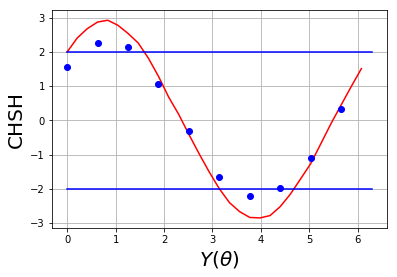

In [21]:
plt.plot(xData, CHSHDataSim, 'r-', xData2, CHSHDataReal, 'bo')
plt.plot([0, 2*np.pi], [2, 2], 'b-')
plt.plot([0, 2*np.pi], [-2, -2], 'b-')
plt.grid()
plt.ylabel('CHSH', fontsize=20)
plt.xlabel(r'$Y(\theta)$', fontsize=20)
plt.show()

Here is the saved CHSH data. 

In [22]:
print(CHSHDataReal)

[1.560546875, 2.263671875, 2.146484375, 1.06640625, -0.306640625, -1.646484375, -2.212890625, -1.97265625, -1.111328125, 0.337890625]


Despite the presence of loopholes in our demonstration, we can see that this experiment is compatible with quantum mechanics as a theory with no local hidden variables.